In [1]:
import mysql.connector

import pandas as pd

connection_mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="wp-ecommerce"
)
 
cursor = connection_mydb.cursor(dictionary=True)

In [2]:
def get_product_categories(product_id):
    sql='''SELECT wp_term_relationships.object_id,wp_term_taxonomy.term_id
            FROM  wp_term_relationships
            INNER JOIN wp_term_taxonomy ON wp_term_relationships.term_taxonomy_id = wp_term_taxonomy.term_taxonomy_id
            WHERE wp_term_taxonomy.taxonomy ='product_cat' and object_id=(%s)
        '''
    
    param = (product_id, )
    
    cursor.execute(sql,param)
    
    results = cursor.fetchall()
    
    ar_ids=[]
    
    for row in results:
        ar_ids.append(row['term_id'])
    
    return ar_ids

In [3]:
get_product_categories(56355)

[79]

In [4]:
def get_category_name_from_id(term_id):

    sql='''SELECT name FROM wp_terms
           LEFT JOIN wp_term_taxonomy 
           ON wp_terms.term_id = wp_term_taxonomy.term_id
           WHERE wp_term_taxonomy.taxonomy = 'product_cat' and  wp_terms.term_id=(%s)
        '''
    param = (term_id, )
    
    cursor.execute(sql,param)
    
    results = cursor.fetchall()
    if results != None and len(results) > 0:
        return results[0]['name']  
    
    return "Unknown Category"

get_category_name_from_id(79)

'مستحضرات تجميل'

In [5]:
def construct_customers_data():
    
    sql = "SELECT distinct(user_id) FROM wp_usermeta order by user_id "
    cursor.execute(sql)
    users_results = cursor.fetchall()

    df = pd.DataFrame(columns=['user_id', 'customer_id', 'country','age', 'gender', 'term_id', 'term_name', 'count_term_id'])
    
    for user in users_results:
        
        country = "UNKNOWN"
        
        age = 0
        
        gender = "UNKNOWN"
        
        user_id = user['user_id']
        customer_id = 0
        
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) and meta_key='country'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        if result != None and len(result) > 0:
            country=result[0]['meta_value']
        
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) and meta_key='age'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        
        if result != None and len(result) > 0:
            age = result[0]['meta_value']
        
        sql = "SELECT * FROM wp_usermeta WHERE user_id=(%s) and meta_key='gender'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result != None and len(result) > 0:
            gender = result[0]['meta_value']
            
        sql = "SELECT * FROM wp_wc_customer_lookup  WHERE user_id=(%s) "
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result != None and len(result) > 0:
            customer_id = result[0]['customer_id']  
        
        sql="SELECT * from wp_wc_order_product_lookup where customer_id=(%s)"
        param = (customer_id, )
        cursor.execute(sql, param)
        results_orders = cursor.fetchall()
        
        categories_list = []
        
        products_list = []
        
        term_id = 0
        
        term_name = ""
        
        count_term_id = 0

        for row in results_orders:
            customer_id = row['customer_id']
            product_id = row['product_id']
            
            term_ids = get_product_categories(product_id)
            for term_id in term_ids:
                add_1_category_customer(categories_list, customer_id, term_id)

        for k in range(len(categories_list)):
            for m in range(k+1, len(categories_list)):
                if (categories_list[k]['count'] < categories_list[m]['count']):
                    z = categories_list[k]
                    categories_list[k] = categories_list[m]
                    categories_list[m] = z

        if len(categories_list) > 0:
            term_id = categories_list[0]['term_id']
            count_term_id = categories_list[0]['count']
            term_name = get_category_name_from_id(term_id)
            x = {
                    "user_id":user_id,
                    "customer_id":customer_id,
                    "country":country,
                    "age":age,
                    "gender":gender,
                    'term_id':term_id,
                    'term_name':term_name,
                    'count_term_id':count_term_id
                }
            df = pd.concat([df, pd.DataFrame([x])], ignore_index=True)
    
    return df

In [6]:
def add_1_category_customer(category_customer_list, customer_id, term_id):
    item = find_item(category_customer_list,customer_id, term_id)
    item['count'] += 1

def find_item(category_customer_list, customer_id, term_id):
    
    for item in category_customer_list:
        if item['customer_id'] == customer_id and item['term_id'] == term_id:
            return item
    
    item = {"customer_id":customer_id,"term_id":term_id,"count":0}
    category_customer_list.append(item)
    
    return item

In [7]:
df = construct_customers_data()
df

,user_id,customer_id,country,age,gender,term_id,term_name,count_term_id
0,1,294,SA,36,انثى,75,ملابس نسائي,4
1,2,736,JO,48,انثى,75,ملابس نسائي,4
2,3,435,KW,40,ذكر,78,إلكترونيات,8
3,5,86,JO,35,انثى,75,ملابس نسائي,4
4,6,245,BH,29,ذكر,74,ملابس رجالي,9
...,...,...,...,...,...,...,...,...
975,995,715,KW,44,انثى,75,ملابس نسائي,3
976,996,467,AE,26,انثى,75,ملابس نسائي,4
977,997,426,BH,54,انثى,75,ملابس نسائي,6
978,998,664,JO,43,ذكر,78,إلكترونيات,7


In [8]:
from sklearn.preprocessing import LabelEncoder

country_LE = LabelEncoder()

gender_LE = LabelEncoder()
df['country'] = country_LE.fit_transform(df['country'])
df['gender'] = gender_LE.fit_transform(df['gender'])

X = df[['country','age','gender']]

y = df['term_id']
y = y.astype(int)

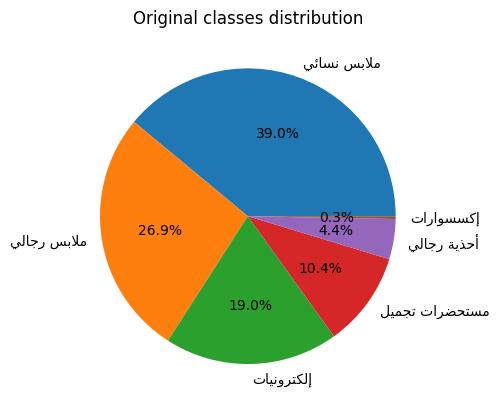

In [9]:
import matplotlib.pyplot as plt

y_labels = df['term_name']

import arabic_reshaper
from bidi.algorithm import get_display

count_values = y_labels.value_counts()

labels = count_values.index.to_list()
labels_A = []

for item in labels:
    labels_A.append(get_display(arabic_reshaper.reshape(item)))

plt.title('Original classes distribution')

plt.pie(x=count_values, labels=labels_A, autopct='%1.1f%%' )

plt.show()

In [10]:
from collections import Counter

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=75, n=382 (38.980%)
Class=78, n=186 (18.980%)
Class=74, n=264 (26.939%)
Class=79, n=102 (10.408%)
Class=76, n=43 (4.388%)
Class=82, n=3 (0.306%)


In [11]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [12]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()

X, y = oversample.fit_resample(X, y)

In [13]:
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=75, n=382 (16.667%)
Class=78, n=382 (16.667%)
Class=74, n=382 (16.667%)
Class=79, n=382 (16.667%)
Class=76, n=382 (16.667%)
Class=82, n=382 (16.667%)


In [14]:
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier


model_DecisionTreeClassifier = DecisionTreeClassifier()
model_CategoricalNB = CategoricalNB()
model_KNeighborsClassifier = KNeighborsClassifier()

scores_accuracy = cross_val_score(model_DecisionTreeClassifier, X, y, cv=10, scoring="accuracy")

meanScore = scores_accuracy.mean()
print("Accuracy DecisionTreeClassifier= ", round(meanScore * 100,2))

scores_accuracy = cross_val_score(model_CategoricalNB, X, y, cv=10, scoring="accuracy")
meanScore = scores_accuracy.mean()
print("Accuracy CategoricalNB = ", round(meanScore * 100,2))

scores_accuracy = cross_val_score(model_KNeighborsClassifier, X, y, cv=10, scoring="accuracy")
meanScore = scores_accuracy.mean()
print("Accuracy KNeighborsClassifier = ", round(meanScore * 100,2))

Accuracy DecisionTreeClassifier=  82.42
Accuracy CategoricalNB =  71.34
Accuracy KNeighborsClassifier =  70.47


In [15]:
model = DecisionTreeClassifier()

model.fit(X.values,y)

DecisionTreeClassifier()

In [16]:
country = 2
age = 22
gender = 0
example = [[country,age,gender]]

pred_proba = model.predict_proba(example)
print(pred_proba)

pred_class = model.predict(example)
print(pred_class)

[[0.  0.  0.5 0.  0.5 0. ]]
[76]


In [17]:
import pickle

filename = 'classification_model'
pickle.dump(model, open(filename, 'wb'))

In [18]:
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(example)
print(result[0])

76


In [19]:
def get_category_code(filename, country, age, gender):
   
    import pickle
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    example=[country,age,gender]

    result = loaded_model.predict([example])
    
    return result[0]

In [20]:
get_category_code('classification_model',1 , 22, 1)

74

In [21]:
pip install m2cgen

Note: you may need to restart the kernel to use updated packages.


In [22]:
import m2cgen as m2c 

model_to_php = m2c.export_to_php(model)  

f = open("predict_category.php", "w")

f.write(model_to_php)

f.close()

In [23]:
cursor = connection_mydb.cursor(dictionary=True)
sql = '''DROP TABLE IF EXISTS custom_country_codes'''
cursor.execute(sql)
sql = '''
        CREATE TABLE custom_country_codes (
        ID int(11) NOT NULL AUTO_INCREMENT,
        code int(11) NOT NULL,
        country char(2) NOT NULL, PRIMARY KEY (ID))ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
      '''
cursor.execute(sql)
connection_mydb.commit()

for country in country_LE.classes_:
    code = country_LE.transform([country])[0]
    sql = "INSERT INTO custom_country_codes (code, country) VALUES (%s, %s)"
    code = int(code)
    val = (code, country)
    cursor.execute(sql, val)
    connection_mydb.commit()

In [24]:
cursor = connection_mydb.cursor(dictionary=True)
sql = '''DROP TABLE IF EXISTS custom_gender_codes'''
cursor.execute(sql)

sql = '''
        CREATE TABLE custom_gender_codes (
        ID int(11) NOT NULL AUTO_INCREMENT,
        code int(11) NOT NULL,
        gender char(10) NOT NULL, PRIMARY KEY (ID))ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
      '''
cursor.execute(sql)
connection_mydb.commit()

for gender in gender_LE.classes_:
    code=gender_LE.transform([gender])[0]
    sql = "INSERT INTO custom_gender_codes (code, gender) VALUES (%s, %s)"
    code = int(code)
    val = (code, gender)
    cursor.execute(sql, val)
    connection_mydb.commit()

In [25]:
def category_best_seller_products(category_id, n=3):
    cursor = connection_mydb.cursor(dictionary=True)
    
    sql = '''SELECT wp_term_taxonomy.term_id,
                  wp_wc_order_product_lookup.product_id,  
                  sum(wp_wc_order_product_lookup.product_qty) as sumsales
                  FROM wp_wc_order_product_lookup 
                  INNER JOIN wp_term_relationships  ON wp_term_relationships.object_id=wp_wc_order_product_lookup.product_id
                  INNER JOIN wp_term_taxonomy ON wp_term_relationships.term_taxonomy_id = wp_term_taxonomy.term_taxonomy_id
                  WHERE wp_term_taxonomy.taxonomy ='product_cat'   and 
                  wp_term_taxonomy.term_id=(%s)
                  group by wp_term_taxonomy.term_id,wp_wc_order_product_lookup.product_id
                  order by sumsales DESC
          '''

    param = (category_id, )
    
    cursor.execute(sql,param)
    results = cursor.fetchall()
    products_ids = []
    if results != None:
        i=0
        while i < n and i < len(results):
            product_id = results[i]['product_id']
            products_ids.append(product_id)
            i = i+1
    return products_ids

In [26]:
category_best_seller_products(78, 3)

[56238, 56217, 56228]

In [27]:
def get_product_name(product_id):
     
    cursor = connection_mydb.cursor(dictionary=True)
    sql = "SELECT post_title FROM wp_posts WHERE ID=(%s)"
    id = (product_id,)
    
    cursor.execute(sql,id)
    
    results = cursor.fetchall()
    if len(results)>0:
        return results[0]['post_title']  
    
    return "Unknown Product"

In [28]:
def get_gender_code(gender):
    cursor = connection_mydb.cursor(dictionary=True)
    
    sql = "SELECT code FROM custom_gender_codes  WHERE gender=(%s) "
    param = (gender, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    if result != None and len(result) > 0:
        return result[0]['code']
    else:
        0

In [29]:
def get_country_code(country):
    cursor = connection_mydb.cursor(dictionary=True)
    
    sql = "SELECT code FROM custom_country_codes  WHERE country=(%s) "
    param = (country, )
    cursor.execute(sql, param)
    result = cursor.fetchall()
    if result != None and len(result) > 0:
        return result[0]['code']
    else:
        0

In [30]:
def get_customer_products(customer_id, n=3):
        cursor = connection_mydb.cursor(dictionary=True)
        user_id = 0
        
        sql = "SELECT user_id FROM wp_wc_customer_lookup  WHERE customer_id=(%s) "
        param = (customer_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result!=None and len(result) > 0:
            user_id=result[0]['user_id']  
       
        country=""
        sql = "SELECT meta_value FROM wp_usermeta  WHERE user_id=(%s) and meta_key='country'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result!=None and len(result) > 0:
            country=result[0]['meta_value']
        
        country_code=get_country_code(country)
 
        age = 0
        sql = "SELECT meta_value FROM wp_usermeta  WHERE user_id=(%s) and meta_key='age'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result != None and len(result)>0:
            age=int(result[0]['meta_value'])

        gender=""
        sql = "SELECT meta_value FROM wp_usermeta  WHERE user_id=(%s) and meta_key='gender'"
        param = (user_id, )
        cursor.execute(sql, param)
        result = cursor.fetchall()
        if result != None and len(result)>0:
            gender = result[0]['meta_value']
            
        gender_code=get_gender_code(gender)
        
        category_code = get_category_code('classification_model', country_code, age, gender_code)
        
        products_ids = category_best_seller_products(int(category_code), n)
        
        products = []
        for id in products_ids:
            product=get_product_name(id)
            products.append(product)
        
        return products

In [31]:
get_customer_products(1)

['فرن-أبيض-LG', 'غسالة-أسود-SAMSUNG', 'غسالة-أسود-LG']